In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理（剔除原油，铜，铁矿石）

## 提取并处理数据

### 权益类资产换手率

In [2]:
Turnovers = pd.read_excel(io="Raw/资产换手率.xlsx")                      # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [3]:
Turnovers = Turnovers[1:-1]

### GC007利率

In [4]:
Rates = pd.read_excel(io="Raw/GC007利率.xlsx")           #  读取数据
Rates = Rates.drop([0, 1, 2], axis=0)                   # 删除多余行
Rates.columns = ['日期', 'GC007']                        # 修改列名
Rates["日期"] = pd.DatetimeIndex(Rates["日期"])           # 类型转换
Rates = Rates.set_index("日期")                          # 设置索引

In [5]:
Rates = Rates[1:-1]                    

### 各资产收盘价

In [6]:
Assets = pd.read_excel(io="Raw/资产收盘价.xlsx")
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引

In [7]:
Assets.tail()

,沪深300,中证500,上证10年国债,信用债3-5AAA,中信证券COMEX铜期货,中信证券COMEX黄金期货,中信证券WTI原油期货,中信证券铁矿石,标普500
日期,,,,,,,,,
2020-07-06,4670.09,6299.86,147.4,200.154,5335.92,15760.9,758.982,2458.91,3179.72
2020-07-07,4698.13,6380.03,147.162,199.612,5352.32,15825.6,755.005,2514.87,3145.32
2020-07-08,4774,6535.42,146.825,199.579,5396.07,15895.8,759.096,2570.83,3169.94
2020-07-09,4840.77,6693.75,146.231,198.999,5414.36,15721.7,734.336,2603.75,3152.05
2020-07-10,4753.13,6676.44,146.231,198.999,5403.39,15689.9,732.848,2603.75,3152.05


### 十年国债&美债收益率

In [8]:
CNRates = pd.read_excel(io="Raw/中债国债到期收益率(中债)(日).xls")        # 读取数据
CNRates.columns = ['日期', '十年国债收益率']                             # 修改列名
CNRates = CNRates.drop([0, 3870, 3871], axis=0)                       # 删除多余行
CNRates["日期"] = pd.DatetimeIndex(CNRates["日期"])                    # 类型转换
CNRates = CNRates.set_index("日期")                                   # 设置索引

In [9]:
USRates = pd.read_excel(io="Raw/美债收益率.xlsx")                       # 读取数据
USRates.columns = ['日期', '十年美债收益率']                             # 修改列名
USRates = USRates.drop([0, 6263, 6264], axis=0)                       # 删除多余行
USRates["日期"] = pd.DatetimeIndex(USRates["日期"])                    # 类型转换
USRates = USRates.set_index("日期")                                    # 设置索引

### 十年国债&美债价格指数

In [10]:
Data = Assets.merge(Rates, how='left', left_index=True, right_index=True)
Data = Data.merge(CNRates, how='left', left_index=True, right_index=True)
Data = Data.merge(USRates, how='left', left_index=True, right_index=True)

In [11]:
Data['持有时长'] = (Data.index - Data.index[0]).days

# 计算十年国债
Data['10年国债价格指数'] = 100 - (Data['十年国债收益率'] - 3.0) * 8.2 + 3.0 * Data['持有时长'] / 365.0
Data['10年国债价格指数'] = Data['10年国债价格指数'].fillna(method='ffill')

#计算十年美债
Data['10年美债价格指数'] = 100 - (Data['十年美债收益率'] - 3.0) * 8.2 + 3.0 * Data['持有时长'] / 365.0
Data['10年美债价格指数'] = Data['10年美债价格指数'].fillna(method='ffill')

In [12]:
# 利用自制10年国债价格指数，替换上证10年国债
Assets['中国10年国债'] = Data['10年国债价格指数'].values
Assets['美国10年国债'] = Data['10年美债价格指数'].values
Assets = Assets.drop('上证10年国债', axis=1)

## 计算各资产收益率

In [13]:
# 去掉没有10年国债数据的日期
Assets = Assets[:-10]

### 日内损益

- 去除WTI原油期货
- 去除COMEX铜期货
- 去除铁矿石期货

In [14]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

In [15]:
Returns = Returns.drop('中信证券WTI原油期货', axis=1)
Returns = Returns.drop('中信证券COMEX铜期货', axis=1)
Returns = Returns.drop('中信证券铁矿石', axis=1)

### 累计损益

In [16]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

In [17]:
cumReturns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,标普500,中国10年国债,美国10年国债
日期,,,,,,,
2020-06-18,0.751032,1.119141,2.012302,1.640893,2.152727,1.571182,1.687777
2020-06-19,0.761120,1.129435,2.012240,1.661886,2.140565,1.569184,1.688752
2020-06-22,0.761740,1.128825,2.010192,1.673456,2.154468,1.565736,1.688132
2020-06-23,0.765407,1.132790,2.006390,1.683614,2.163748,1.566071,1.687335
2020-06-24,0.768600,1.129813,2.006052,1.674342,2.107804,1.570932,1.690082


### 杠杆调整后的债券净值

In [18]:
lever = 2.0                                 # 杠杆
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

# 更新杠杆调整后的债券净值
leverReturns.loc[:, ['中国10年国债', '信用债3-5AAA']] = Returns.loc[:, ['中国10年国债', '信用债3-5AAA']] * (1.0 + lever) - Rates.values * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

In [19]:
leverCumReturns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,标普500,中国10年国债,美国10年国债
日期,,,,,,,
2020-06-18,0.751032,1.119141,4.942358,1.640893,2.152727,2.303008,1.687777
2020-06-19,0.761120,1.129435,4.941123,1.661886,2.140565,2.293859,1.688752
2020-06-22,0.761740,1.128825,4.925184,1.673456,2.154468,2.278346,1.688132
2020-06-23,0.765407,1.132790,4.896426,1.683614,2.163748,2.279431,1.687335
2020-06-24,0.768600,1.129813,4.892953,1.674342,2.107804,2.300194,1.690082


# 风险平价 + 杠杆策略（指数权重EMA）

## 程序运行

In [20]:
tradeDF, weightDF = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema')

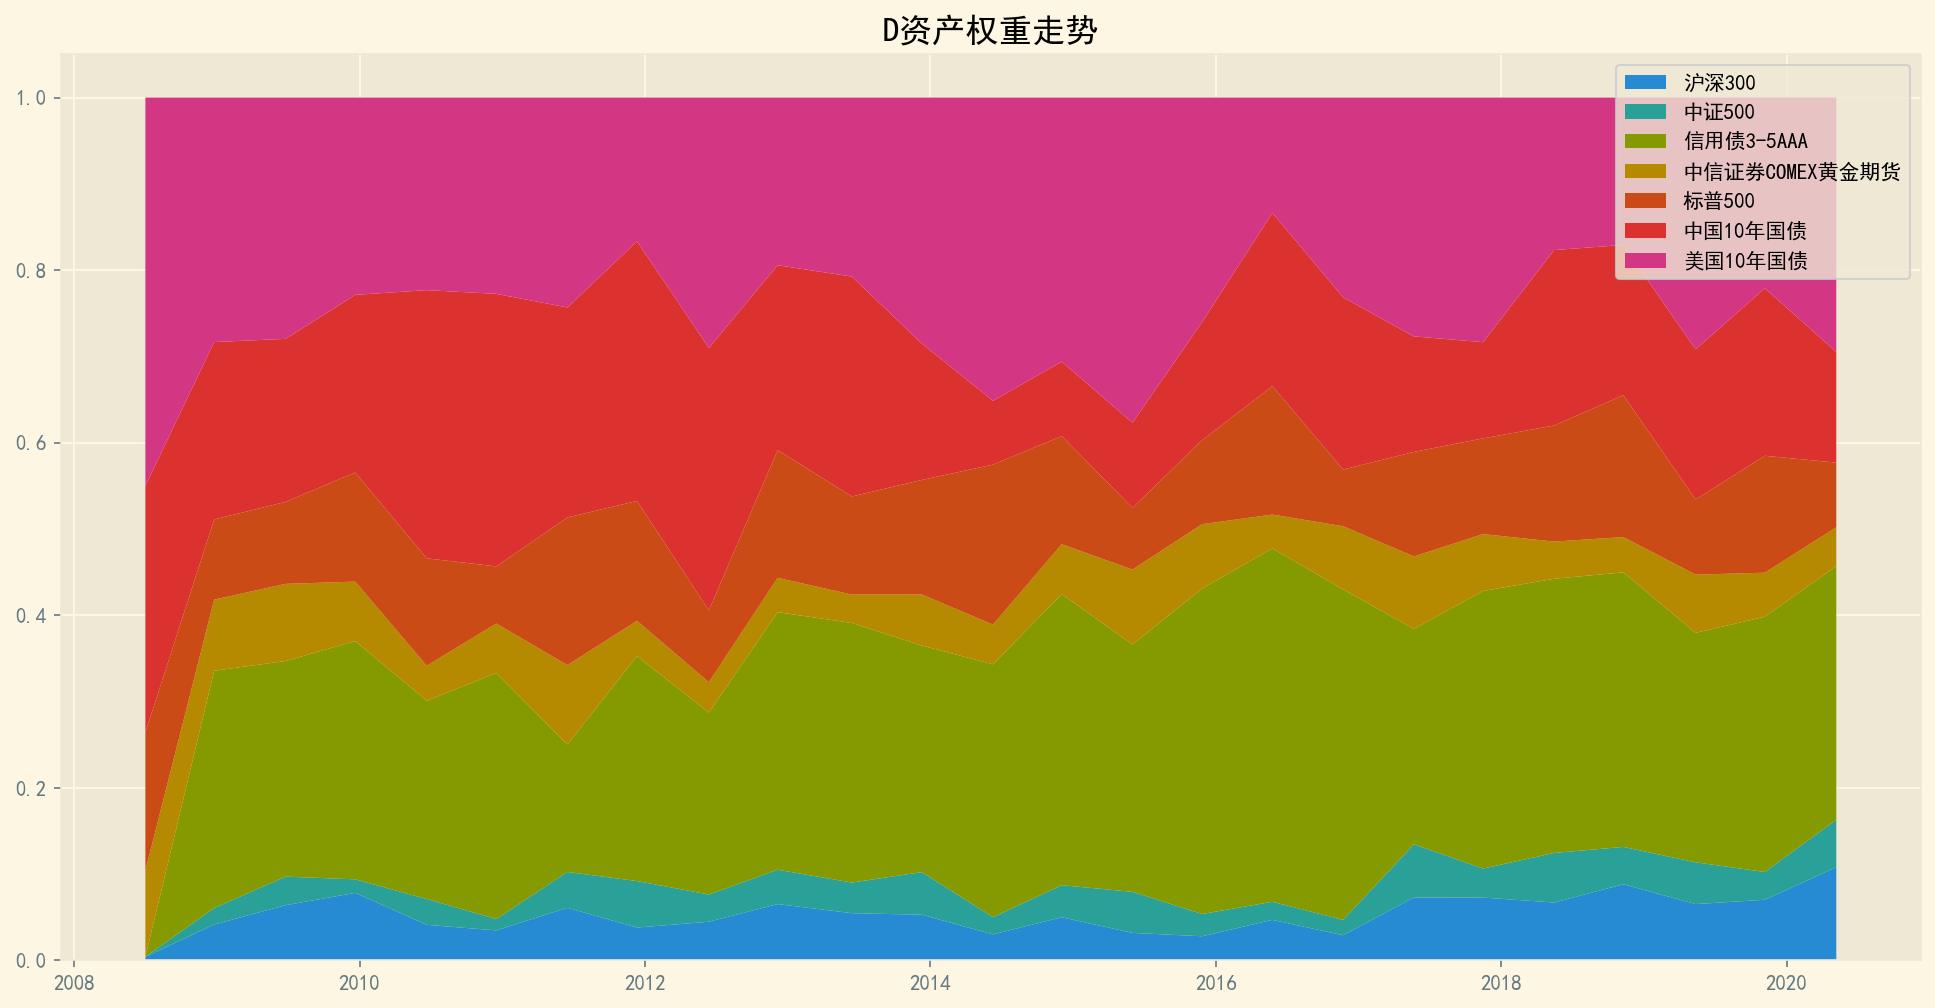

In [26]:
StatisticFunc.WeightPlot(tradeDF, weightDF, 'D')

## 回测表现汇总

In [22]:
# 表现汇总
years = np.unique(tradeDF.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF = pd.DataFrame(index=years)

SummaryDF["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF['投资组合净值']) )
SummaryDF["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF['投资组合净值'])).values
SummaryDF["无基准夏普比率"] = SummaryDF['年收益率'] / SummaryDF['年波动率']
SummaryDF["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF['最大回撤'])).values

SummaryDF

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.200773,0.089616,2.24038,-0.026002
2009,0.0599853,0.065818,0.911387,-0.033627
2010,0.06386,0.050125,1.27402,-0.062468
2011,0.0809654,0.059791,1.35415,-0.076954
2012,0.0670996,0.034145,1.96512,-0.029975
2013,-0.0441746,0.049607,-0.890491,-0.106167
2014,0.182621,0.032443,5.62891,-0.107713
2015,0.148627,0.043693,3.40162,-0.031350
2016,0.0278491,0.035388,0.786964,-0.071259
2017,0.00323524,0.026264,0.123181,-0.079700


## 收益率贡献度

In [23]:
annualContrb = StatisticFunc.AnnualContribution(tradeDF=tradeDF, weightDF=weightDF, assetDF=leverCumReturns)

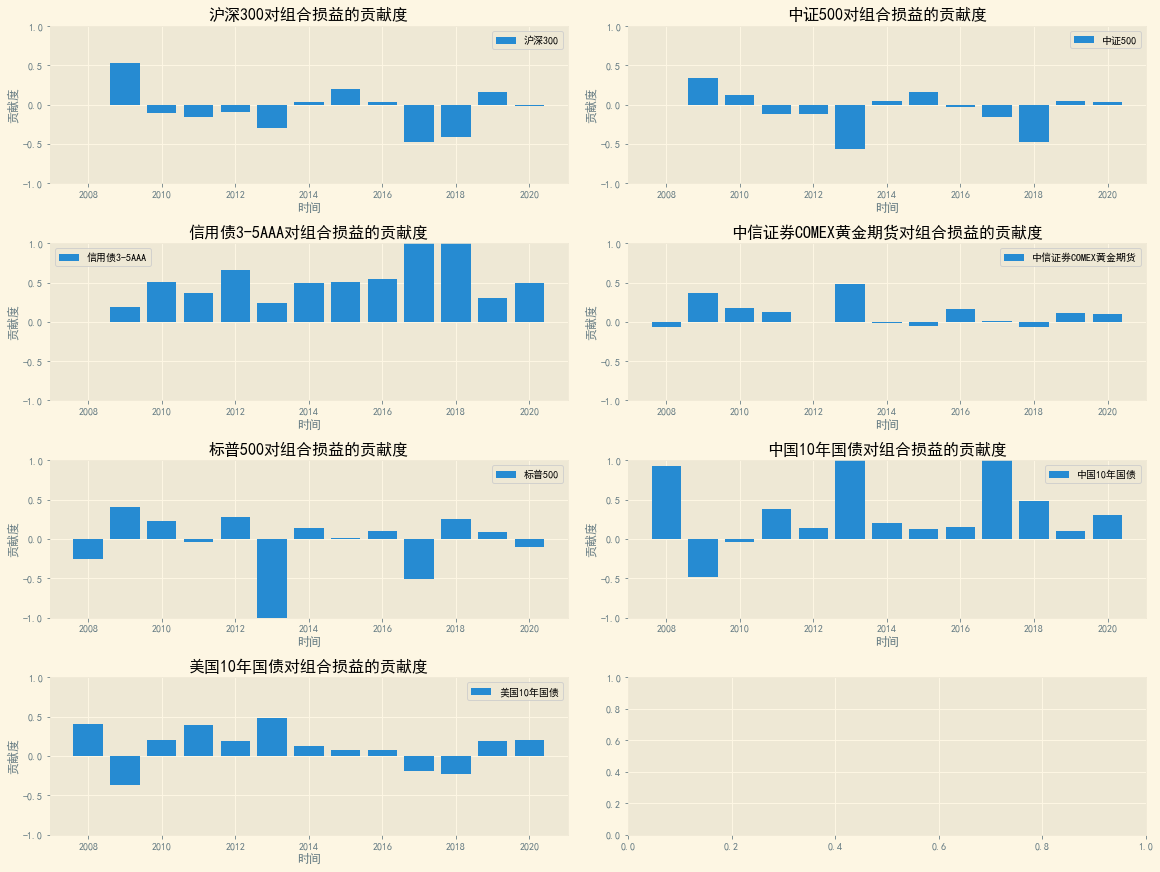

In [24]:
StatisticFunc.BarPlot(annualContrb, 'D')

## 投资组合净值曲线

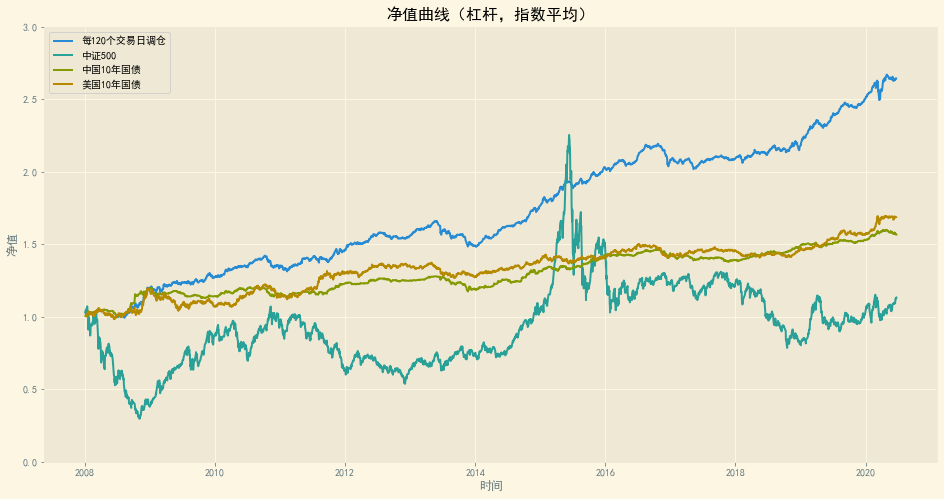

In [25]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, label='每120个交易日调仓')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['中国10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['美国10年国债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均）')
plt.savefig('净值曲线（杠杆，指数平均）D.png')

# 基准组合（横截面动量+时序动量+换手率+铜金+铜油）

## 程序运行

In [27]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF, weightDF = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

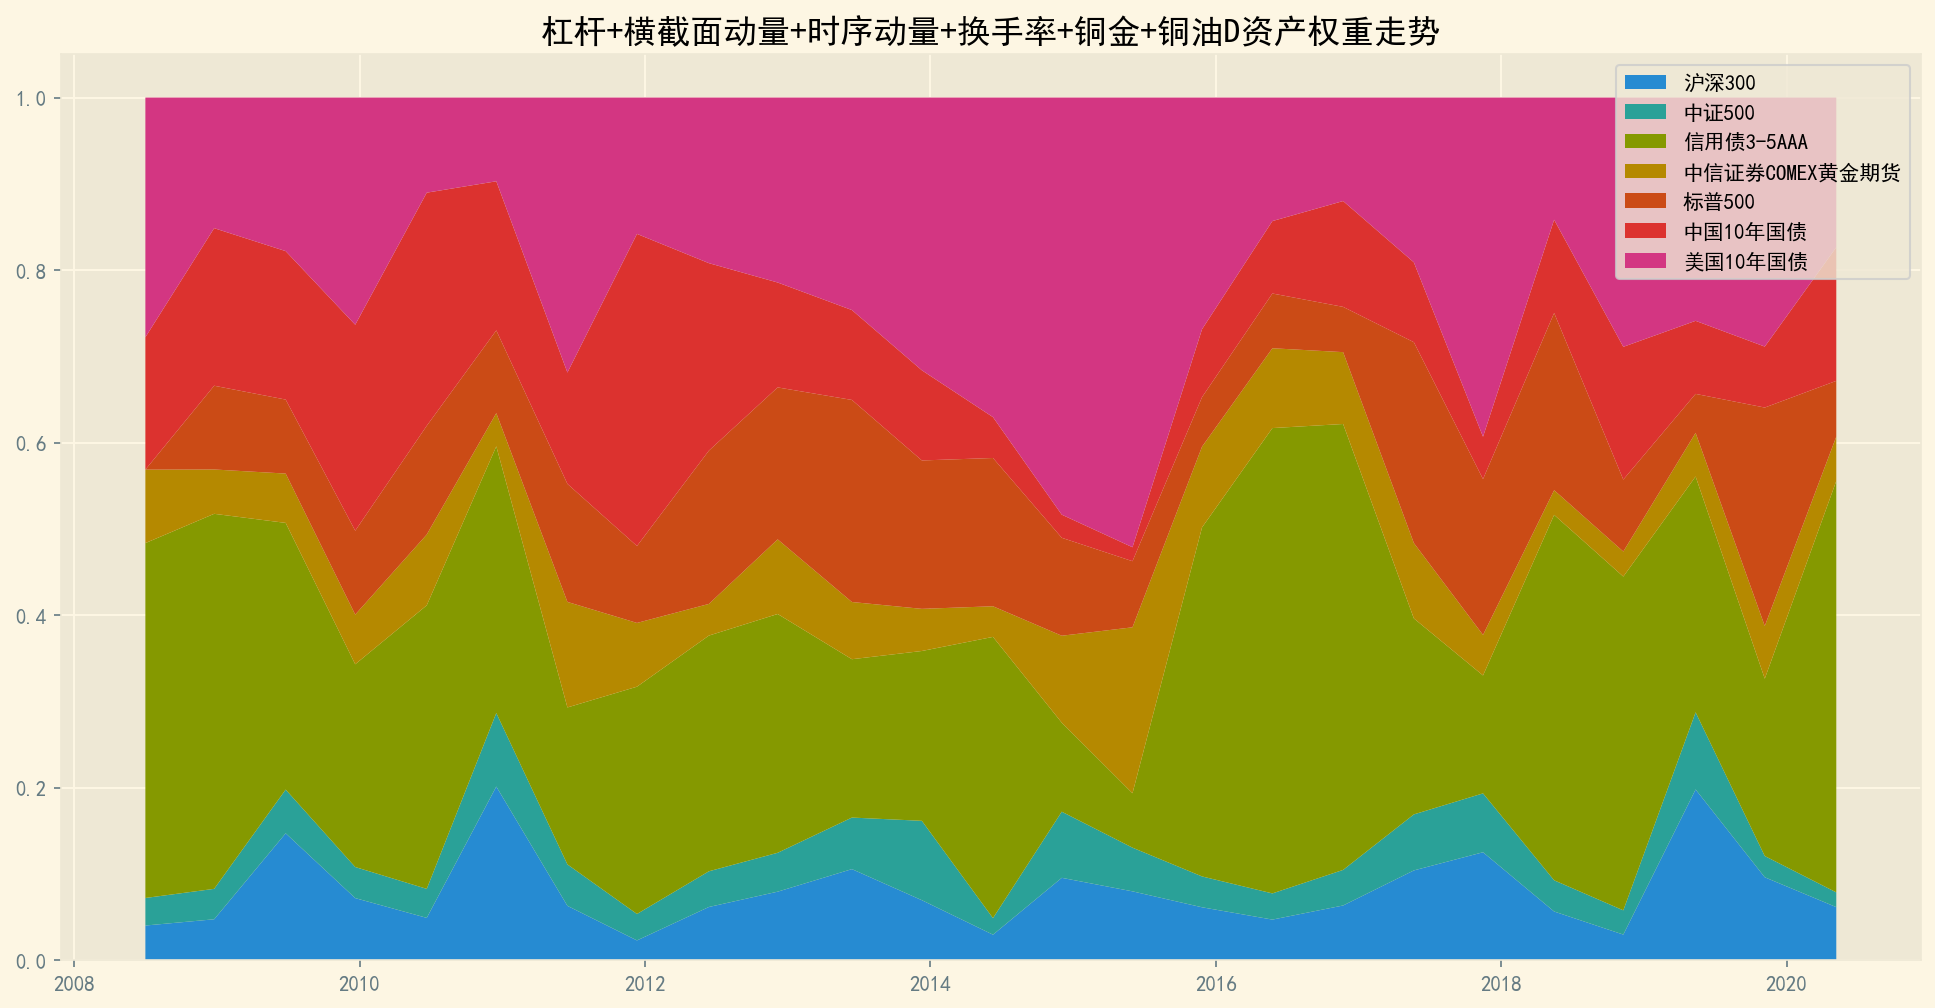

In [28]:
StatisticFunc.WeightPlot(tradeDF, weightDF, '杠杆+横截面动量+时序动量+换手率+铜金+铜油D')

## 回测表现汇总

In [29]:
# 表现汇总
years = np.unique(tradeDF.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF = pd.DataFrame(index=years)

SummaryDF["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF['投资组合净值']) )
SummaryDF["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF['投资组合净值'])).values
SummaryDF["无基准夏普比率"] = SummaryDF['年收益率'] / SummaryDF['年波动率']
SummaryDF["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF['最大回撤'])).values

SummaryDF

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.219751,0.098658,2.2274,-0.038776
2009,0.100017,0.084399,1.18505,-0.048592
2010,0.0619983,0.053916,1.14991,-0.066291
2011,0.0513845,0.068272,0.752646,-0.080275
2012,0.0673842,0.037194,1.81168,-0.028342
2013,-0.000827711,0.054512,-0.015184,-0.066189
2014,0.176168,0.034250,5.14362,-0.060434
2015,0.124863,0.067826,1.84094,-0.064136
2016,0.0181732,0.039014,0.465815,-0.077132
2017,0.0194865,0.029810,0.653683,-0.089808


## 收益率贡献度

In [30]:
annualContrb = StatisticFunc.AnnualContribution(tradeDF=tradeDF, weightDF=weightDF, assetDF=leverCumReturns)

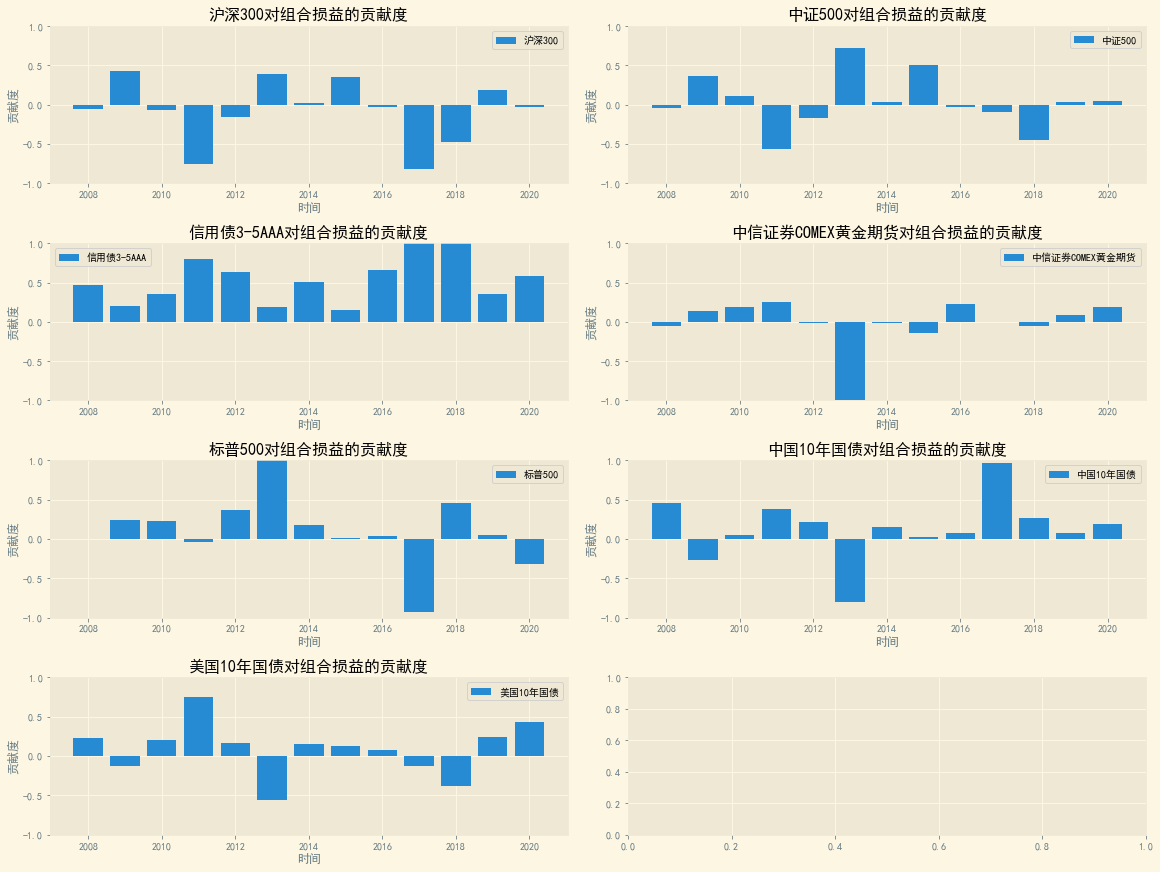

In [31]:
StatisticFunc.BarPlot(annualContrb, '横截面动量+时序动量+换手率+铜金+铜油D')

## 投资组合净值曲线

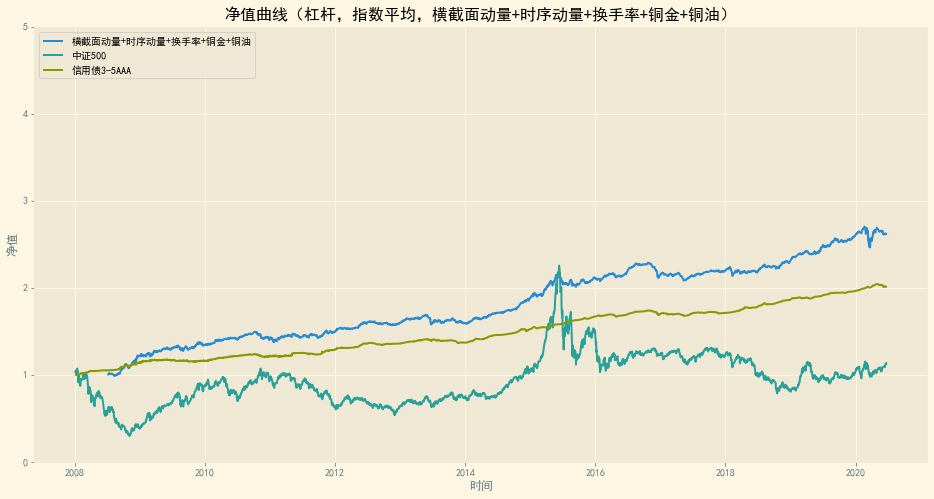

In [32]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）D.png')

# 风险平价 + 杠杆 + 多因子策略（指数平均）

## 换手率+铜金+铜油

### 程序运行

In [65]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_1, weightDF_1 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

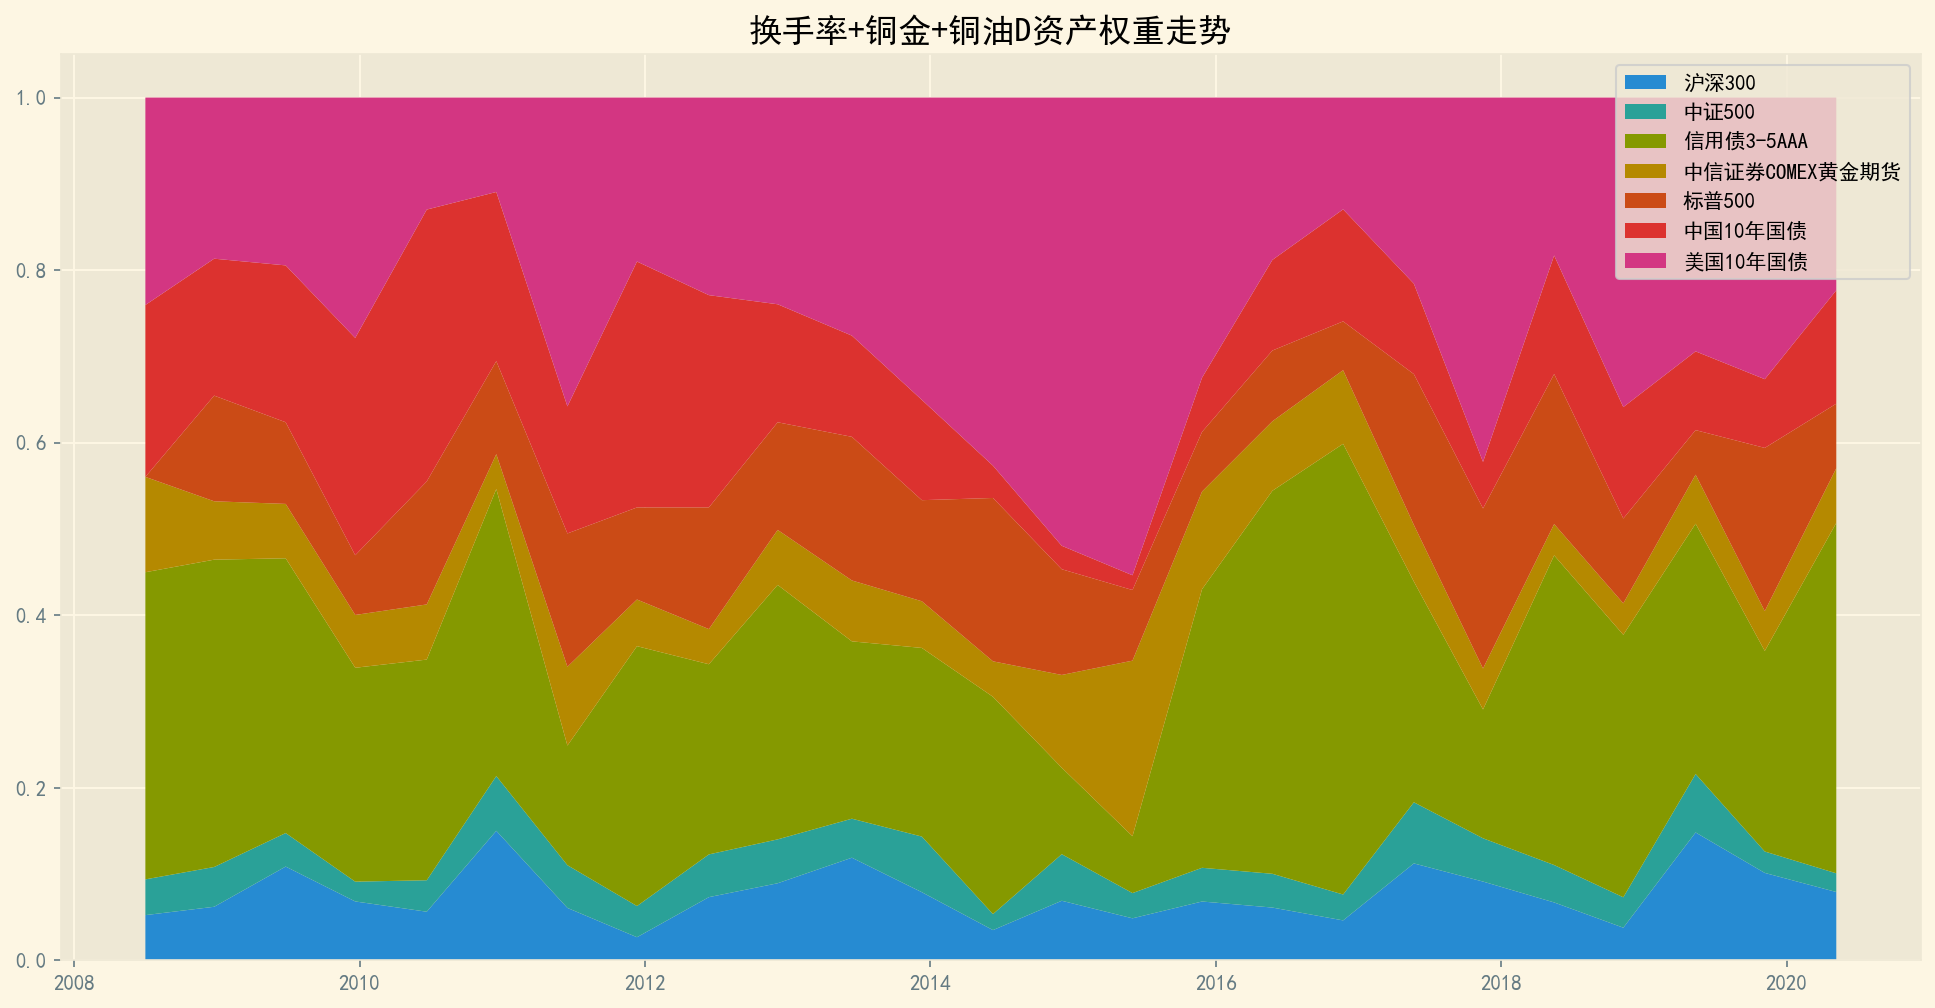

In [66]:
StatisticFunc.WeightPlot(tradeDF_1, weightDF_1, '换手率+铜金+铜油D')

### 回测表现汇总

In [67]:
# 表现汇总
years = np.unique(tradeDF_1.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_1 = pd.DataFrame(index=years)

SummaryDF_1["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_1['投资组合净值']) )
SummaryDF_1["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_1['投资组合净值'])).values
SummaryDF_1["无基准夏普比率"] = SummaryDF_1['年收益率'] / SummaryDF_1['年波动率']
SummaryDF_1["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_1['最大回撤'])).values

SummaryDF_1

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.219257,0.101297,2.1645,-0.041192
2009,0.108951,0.078777,1.38303,-0.039918
2010,0.0727523,0.052940,1.37425,-0.061609
2011,0.0597601,0.063775,0.937053,-0.072509
2012,0.0698769,0.036016,1.94019,-0.029588
2013,-0.0196373,0.053169,-0.369336,-0.073113
2014,0.167985,0.031562,5.32239,-0.076506
2015,0.103135,0.056168,1.83617,-0.041682
2016,0.0192134,0.040528,0.474072,-0.075552
2017,0.0193006,0.028311,0.681732,-0.087681


### 收益率贡献度

In [68]:
annualContrb_1 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_1, weightDF=weightDF_1, assetDF=leverCumReturns)

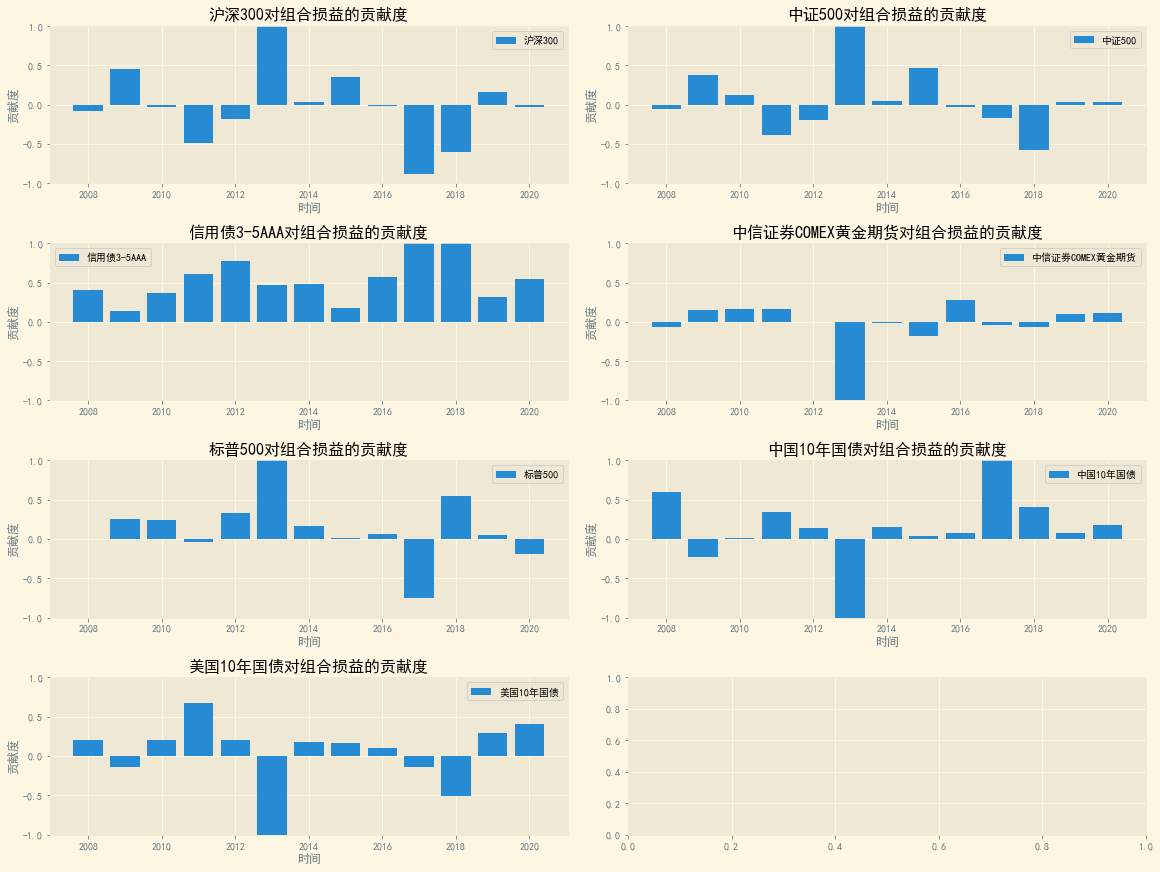

In [69]:
StatisticFunc.BarPlot(annualContrb_1, '时序动量+换手率+铜金+铜油D')

### 投资组合净值曲线

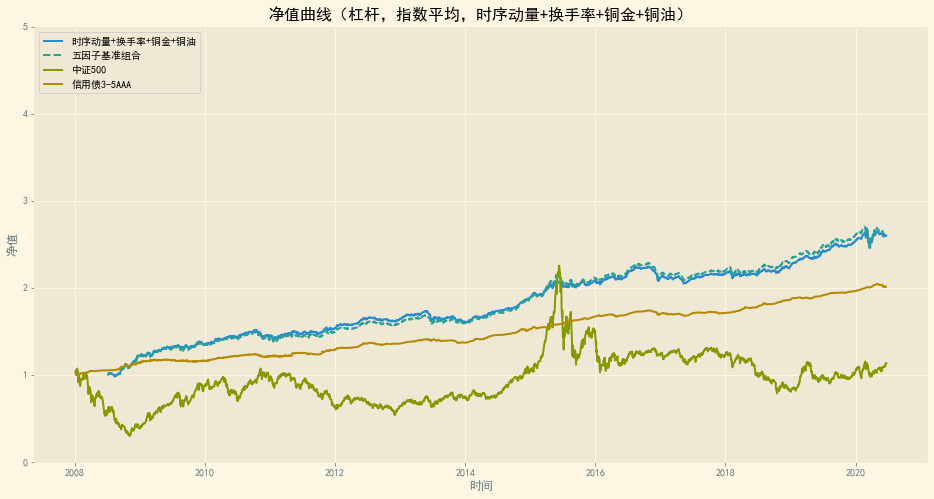

In [70]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='时序动量+换手率+铜金+铜油')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，时序动量+换手率+铜金+铜油）D.png')

## 横截面动量+换手率+铜金+铜油

### 程序运行

In [39]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_2, weightDF_2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

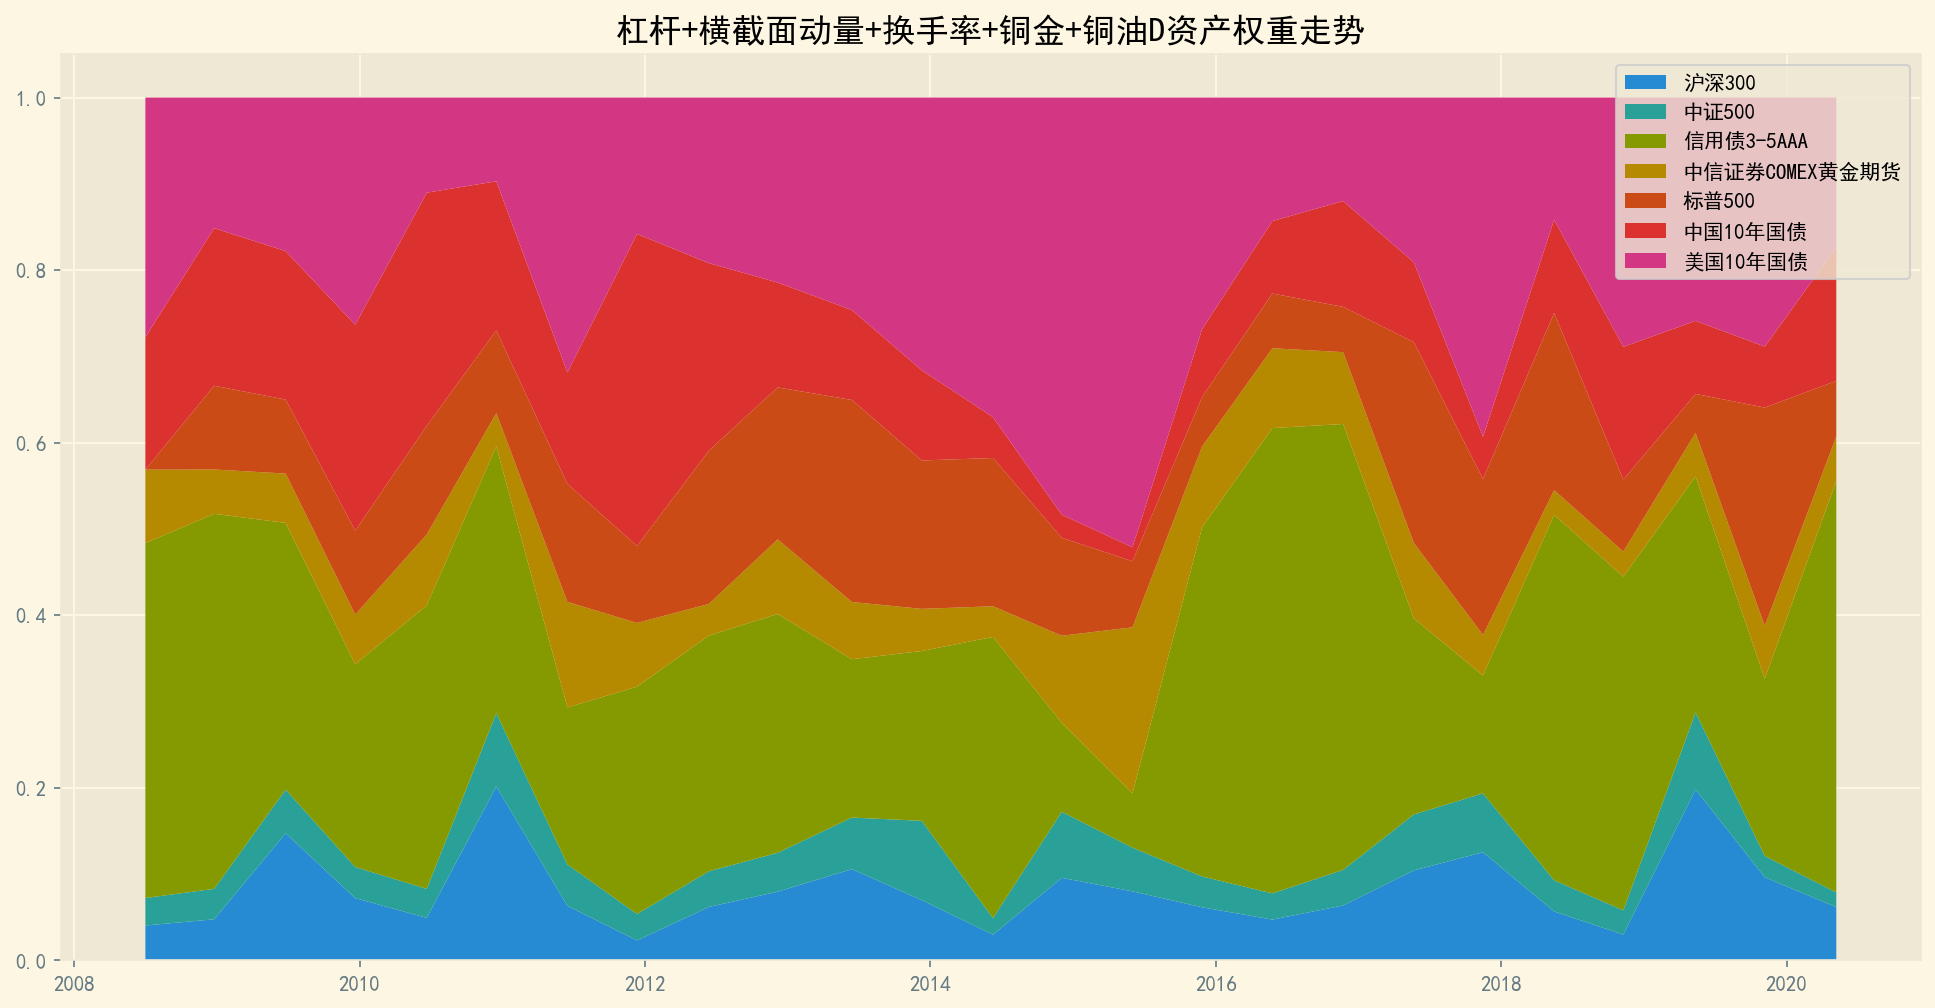

In [40]:
StatisticFunc.WeightPlot(tradeDF_2, weightDF_2, '杠杆+横截面动量+换手率+铜金+铜油D')

### 回测表现汇总

In [41]:
# 表现汇总
years = np.unique(tradeDF_2.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_2 = pd.DataFrame(index=years)

SummaryDF_2["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_2['投资组合净值']) )
SummaryDF_2["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_2['投资组合净值'])).values
SummaryDF_2["无基准夏普比率"] = SummaryDF_2['年收益率'] / SummaryDF_2['年波动率']
SummaryDF_2["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_2['最大回撤'])).values

SummaryDF_2

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.219751,0.098658,2.2274,-0.038776
2009,0.100017,0.084399,1.18505,-0.048592
2010,0.0619983,0.053916,1.14991,-0.066291
2011,0.0513845,0.068272,0.752646,-0.080275
2012,0.0673842,0.037194,1.81168,-0.028342
2013,-0.000827711,0.054512,-0.015184,-0.066189
2014,0.176168,0.034250,5.14362,-0.060434
2015,0.124863,0.067826,1.84094,-0.064136
2016,0.0181732,0.039014,0.465815,-0.077132
2017,0.0194865,0.029810,0.653683,-0.089808


### 收益率贡献度

In [42]:
annualContrb_2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_2, weightDF=weightDF_2, assetDF=leverCumReturns)

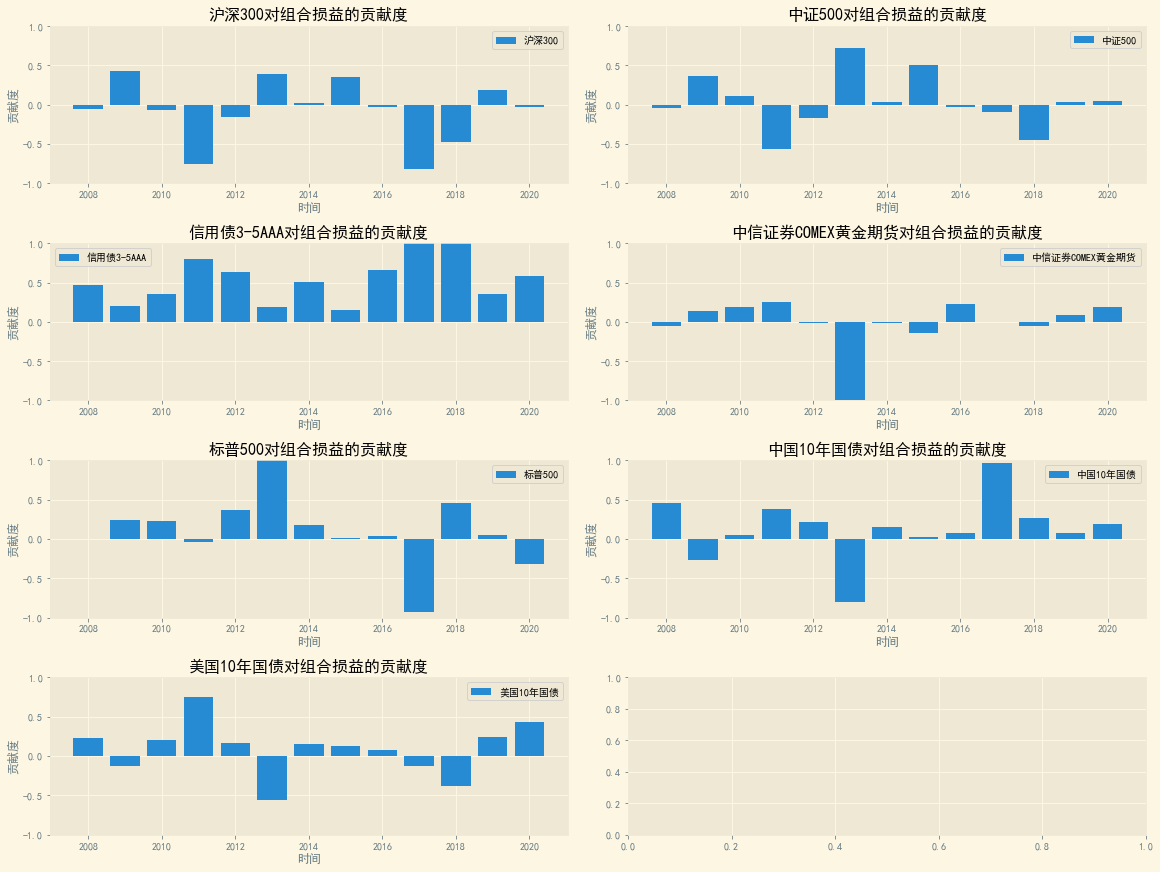

In [43]:
StatisticFunc.BarPlot(annualContrb_2, '横截面动量+换手率+铜金+铜油D')

### 投资组合净值曲线

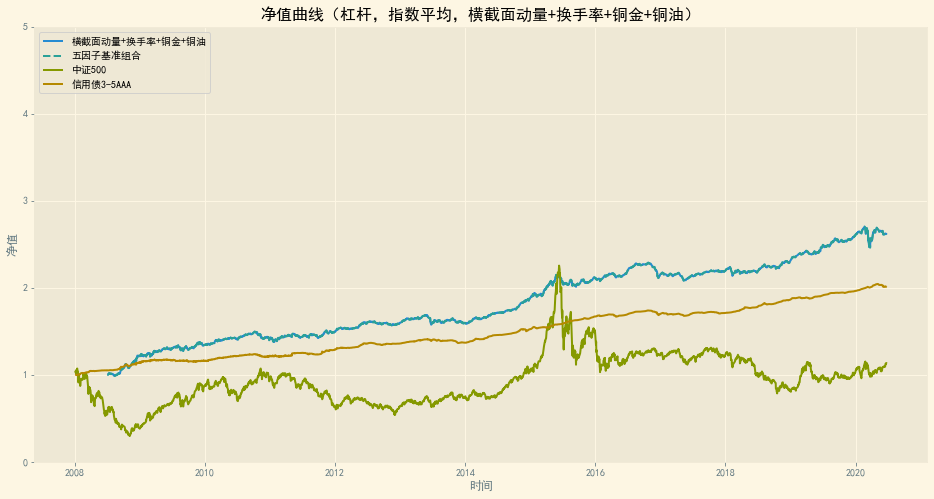

In [44]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量+换手率+铜金+铜油')
        
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')  
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）D.png')

## 横截面动量+时序动量+铜金+铜油

### 程序运行

In [45]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':True, 'copperGas':True}

tradeDF_3, weightDF_3 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

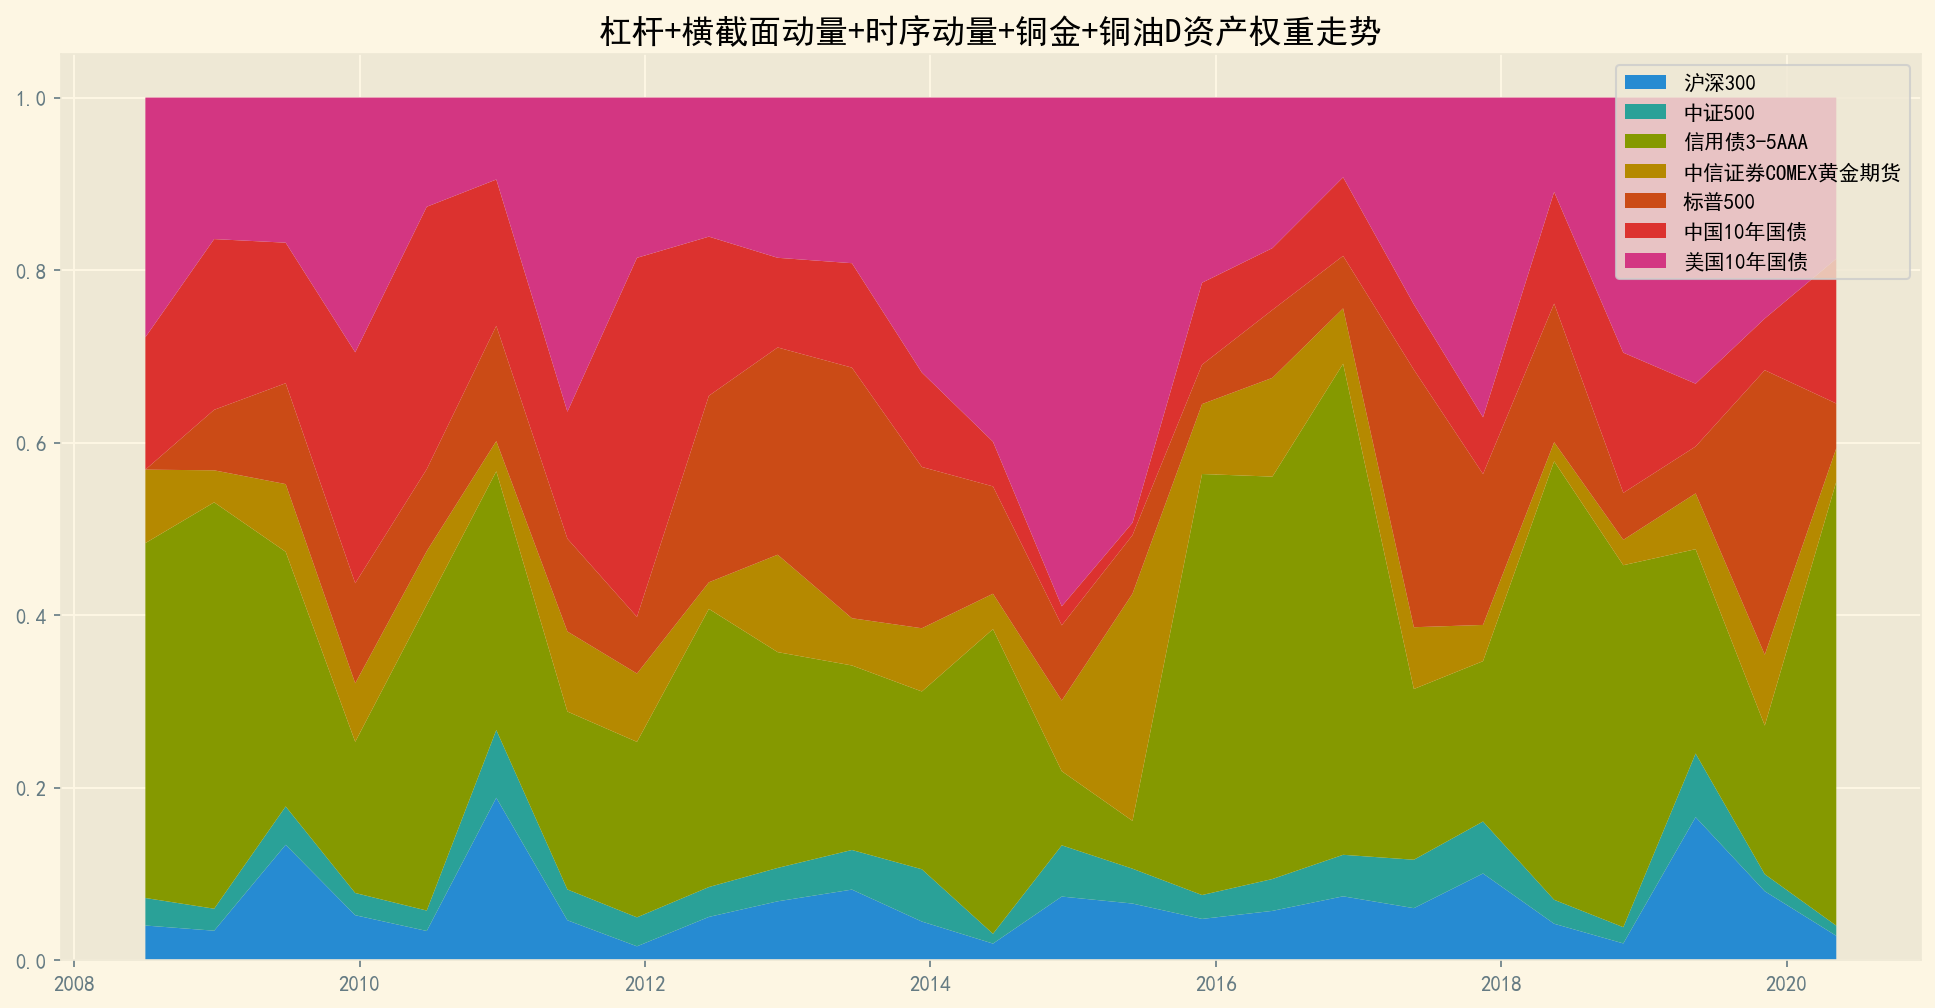

In [46]:
StatisticFunc.WeightPlot(tradeDF_3, weightDF_3, '杠杆+横截面动量+时序动量+铜金+铜油D')

### 回测表现汇总

In [47]:
# 表现汇总
years = np.unique(tradeDF_3.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_3 = pd.DataFrame(index=years)

SummaryDF_3["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_3['投资组合净值']) )
SummaryDF_3["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_3['投资组合净值'])).values
SummaryDF_3["无基准夏普比率"] = SummaryDF_3['年收益率'] / SummaryDF_3['年波动率']
SummaryDF_3["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_3['最大回撤'])).values

SummaryDF_3

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.218988,0.098764,2.21728,-0.038776
2009,0.0883199,0.082248,1.07383,-0.044188
2010,0.0517151,0.051606,1.00211,-0.074767
2011,0.0618163,0.063721,0.970113,-0.086560
2012,0.061918,0.038610,1.60368,-0.028137
2013,0.00400733,0.054726,0.0732257,-0.062547
2014,0.175346,0.030734,5.70532,-0.054660
2015,0.100908,0.062458,1.61561,-0.056737
2016,0.015079,0.038232,0.394408,-0.075840
2017,0.0139785,0.028733,0.486494,-0.090493


### 收益率贡献度

In [48]:
annualContrb_3 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_3, weightDF=weightDF_3, assetDF=leverCumReturns)

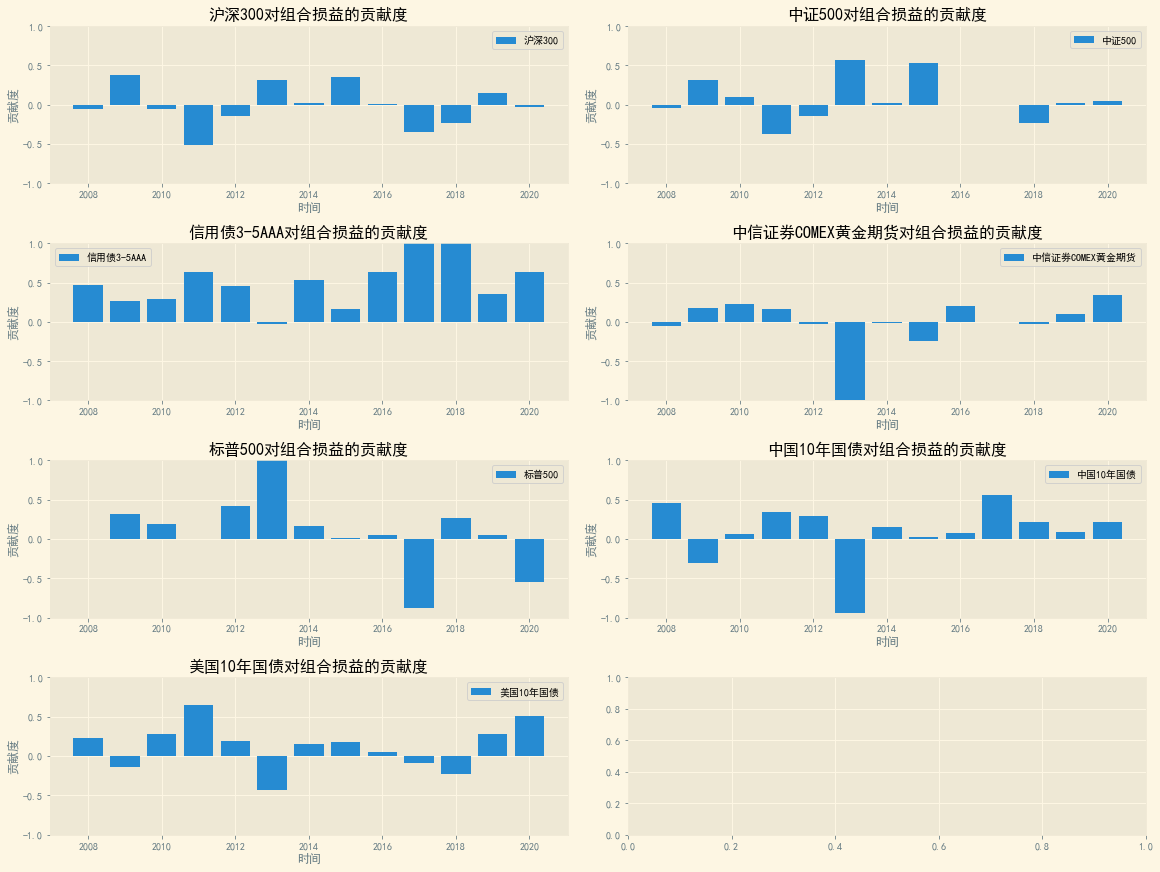

In [49]:
StatisticFunc.BarPlot(annualContrb_3, '横截面动量+时序动量+铜金+铜油D')

### 投资组合净值曲线

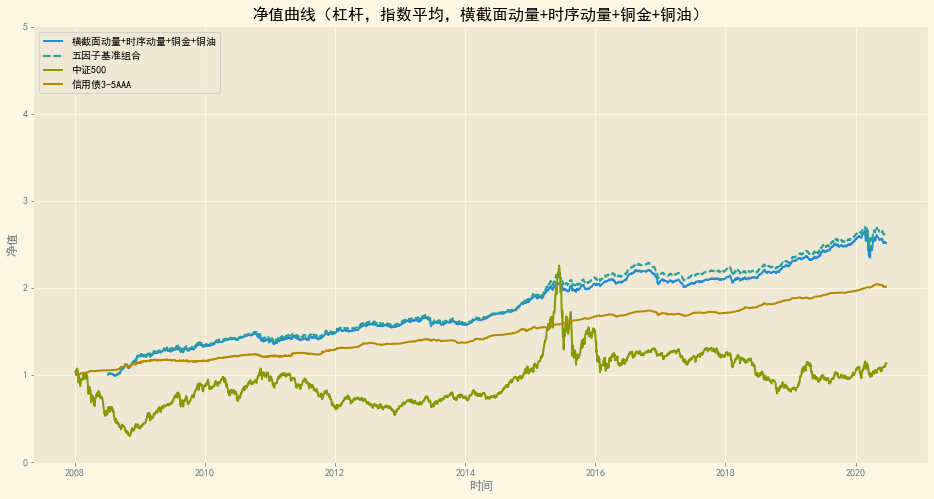

In [50]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='横截面动量+时序动量+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')  
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+铜金+铜油）D.png')

## 横截面动量+时序动量+换手率+铜油

### 程序运行

In [51]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':False, 'copperGas':True}

tradeDF_4, weightDF_4 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

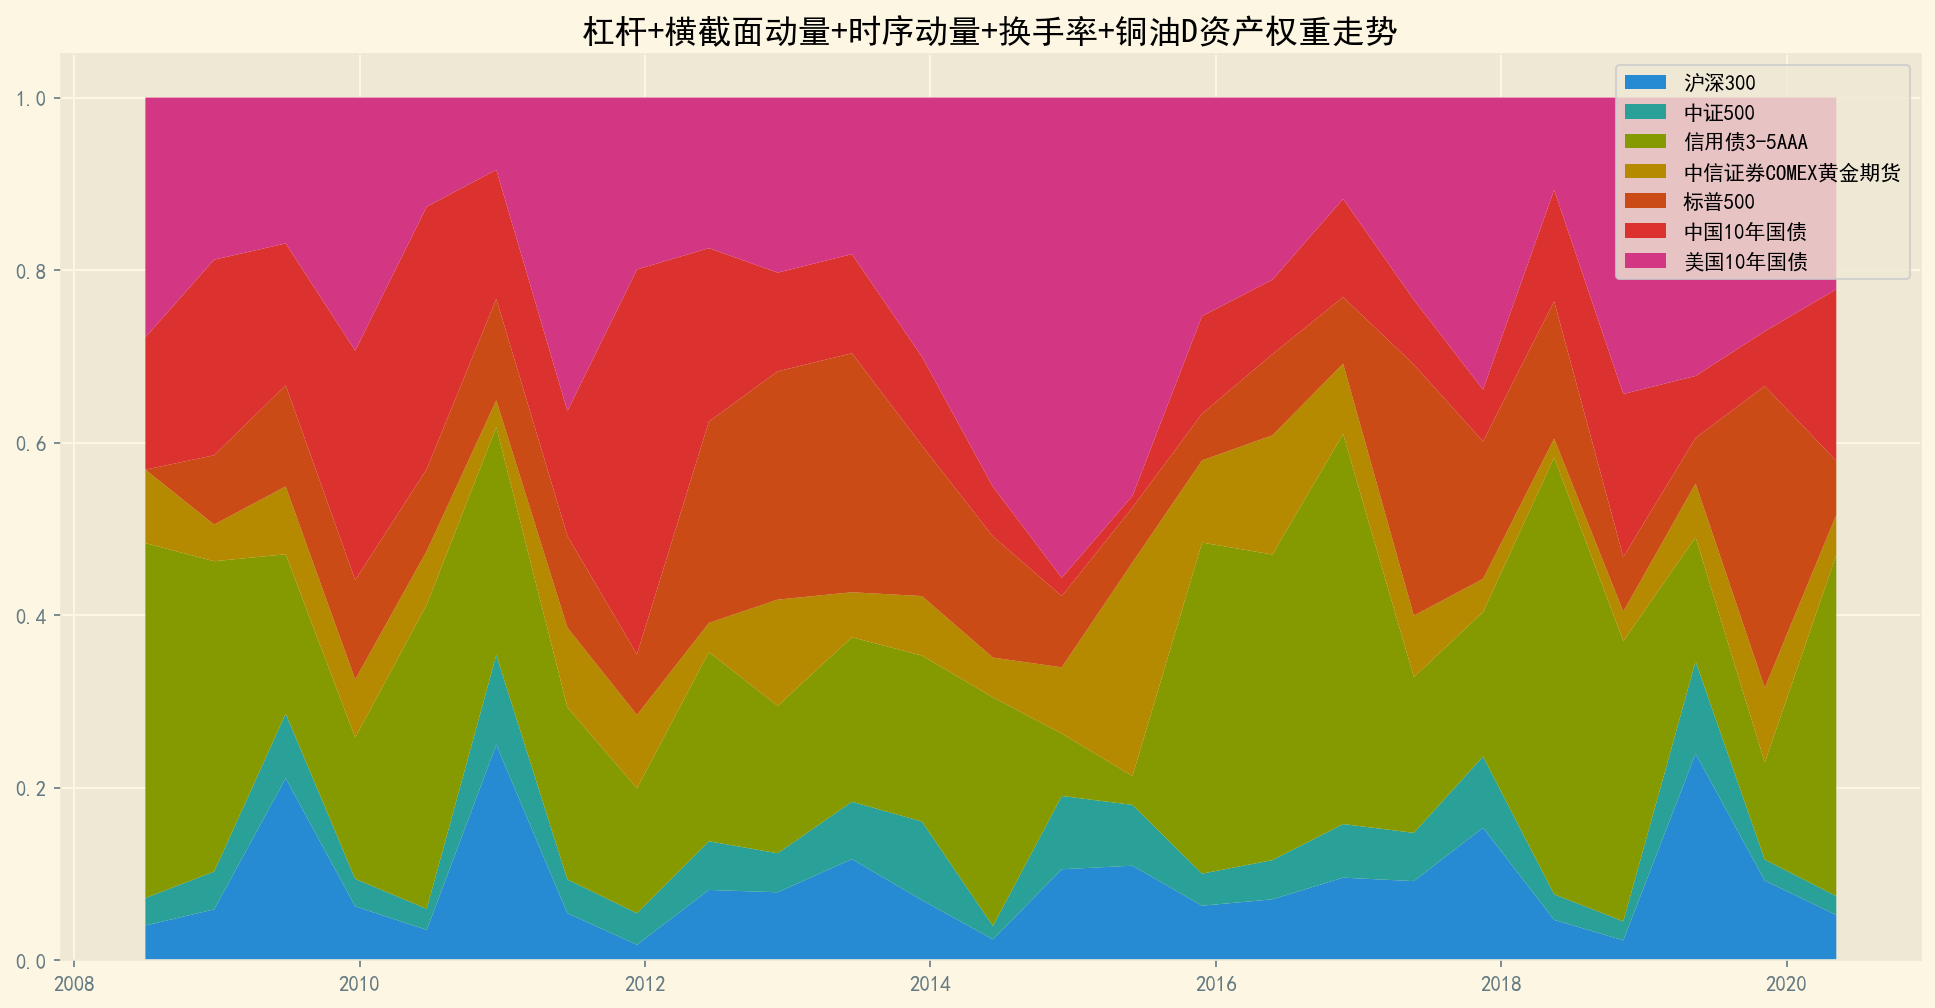

In [52]:
StatisticFunc.WeightPlot(tradeDF_4, weightDF_4, '杠杆+横截面动量+时序动量+换手率+铜油D')

### 回测表现汇总

In [53]:
# 表现汇总
years = np.unique(tradeDF_4.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_4 = pd.DataFrame(index=years)

SummaryDF_4["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_4['投资组合净值']) )
SummaryDF_4["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_4['投资组合净值'])).values
SummaryDF_4["无基准夏普比率"] = SummaryDF_4['年收益率'] / SummaryDF_4['年波动率']
SummaryDF_4["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_4['最大回撤'])).values

SummaryDF_4

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.215669,0.098338,2.19315,-0.038776
2009,0.127938,0.098886,1.2938,-0.072195
2010,0.0434015,0.053132,0.816865,-0.079259
2011,0.0484717,0.069116,0.701311,-0.094742
2012,0.0520662,0.042178,1.23445,-0.031611
2013,0.00264361,0.060161,0.0439424,-0.068046
2014,0.170009,0.035639,4.77029,-0.055029
2015,0.109804,0.079592,1.37959,-0.089833
2016,0.0128673,0.040842,0.315052,-0.073482
2017,0.0240062,0.030919,0.776412,-0.083415


### 收益率贡献度

In [54]:
annualContrb_4 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_4, weightDF=weightDF_4, assetDF=leverCumReturns)

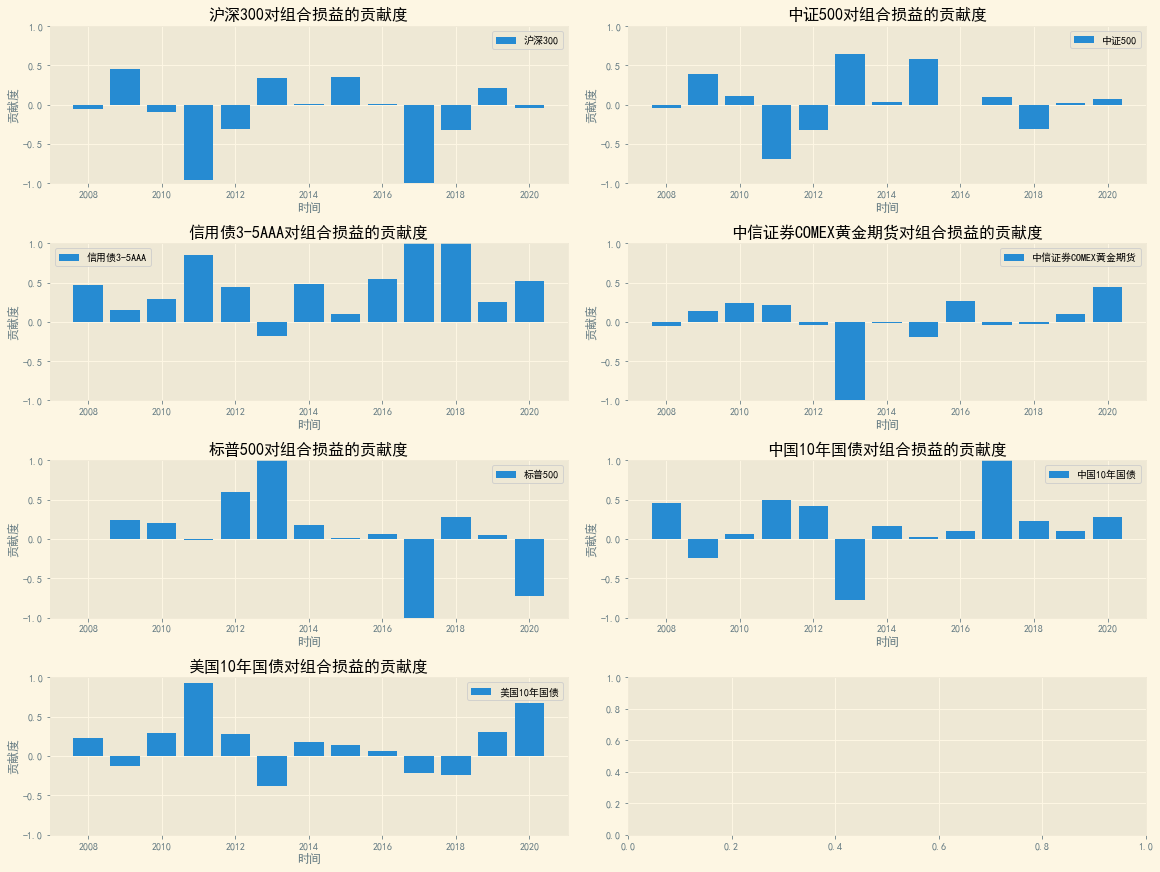

In [55]:
StatisticFunc.BarPlot(annualContrb_4, '横截面动量+时序动量+换手率+铜油D')

### 投资组合净值曲线

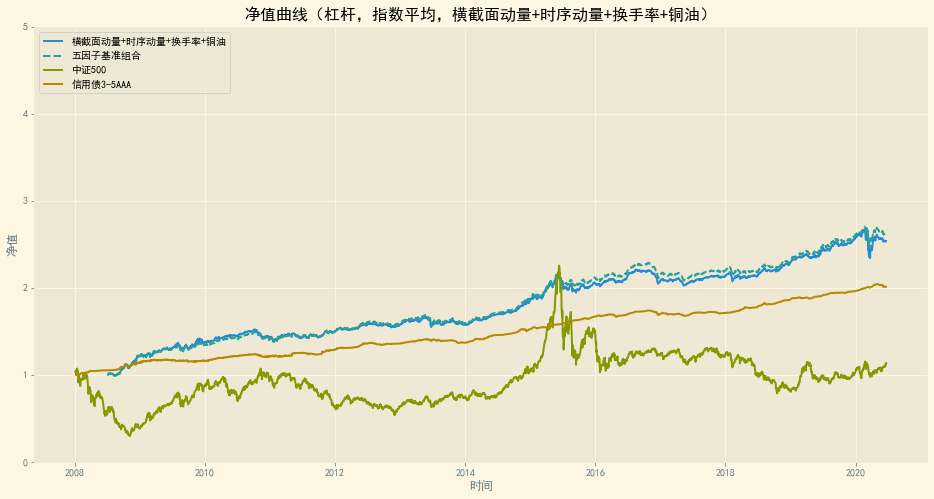

In [56]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_4.index, tradeDF_4['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜油')
    
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')  
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜油）D.png')

## 横截面动量+时序动量+换手率+铜金

### 程序运行

In [57]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':False}

tradeDF_5, weightDF_5 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

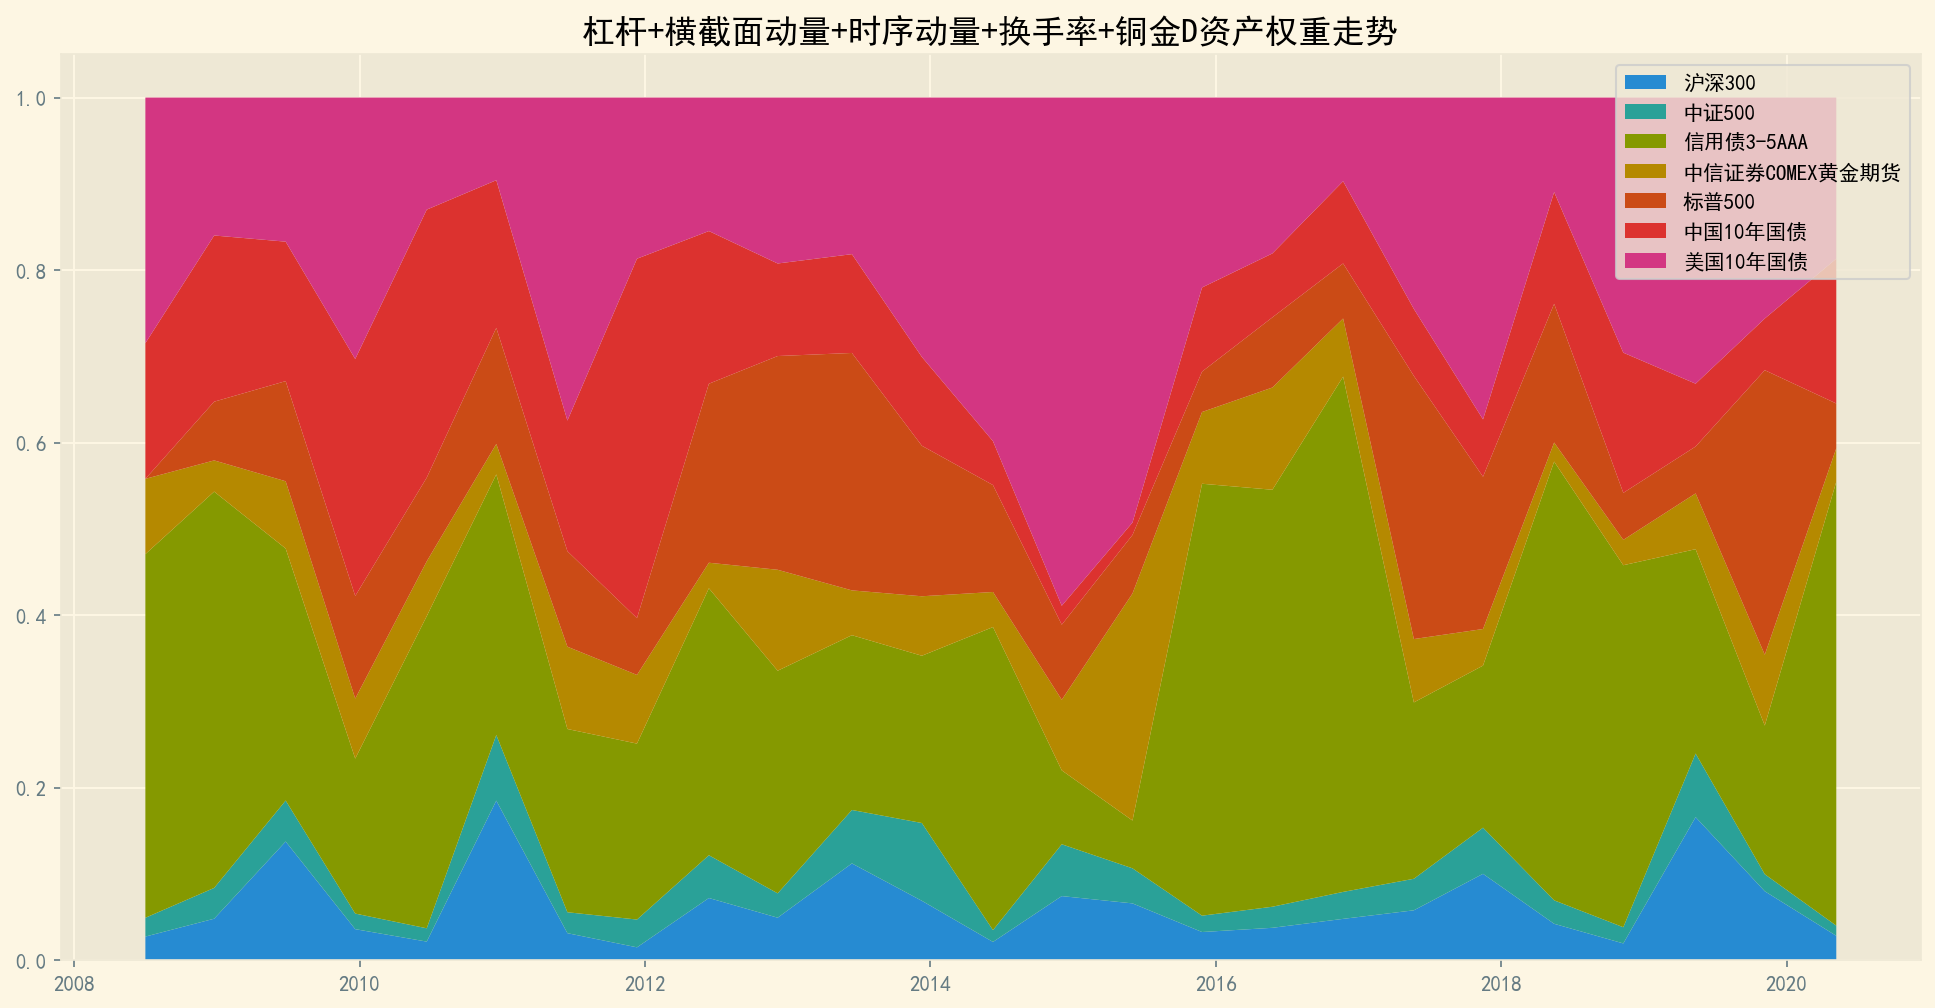

In [58]:
StatisticFunc.WeightPlot(tradeDF_5, weightDF_5, '杠杆+横截面动量+时序动量+换手率+铜金D')

### 回测表现汇总

In [59]:
# 表现汇总
years = np.unique(tradeDF_5.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_5 = pd.DataFrame(index=years)

SummaryDF_5["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_5['投资组合净值']) )
SummaryDF_5["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_5['投资组合净值'])).values
SummaryDF_5["无基准夏普比率"] = SummaryDF_5['年收益率'] / SummaryDF_5['年波动率']
SummaryDF_5["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_5['最大回撤'])).values

SummaryDF_5

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.230375,0.098917,2.32897,-0.037310
2009,0.105629,0.084116,1.25575,-0.045972
2010,0.0537865,0.050978,1.0551,-0.077259
2011,0.0685299,0.063421,1.08056,-0.088748
2012,0.0503495,0.039489,1.27503,-0.030616
2013,0.00689292,0.056399,0.122218,-0.063445
2014,0.16945,0.032905,5.14974,-0.052609
2015,0.101218,0.062631,1.61611,-0.056929
2016,0.0182856,0.036988,0.494366,-0.077813
2017,0.0106896,0.027753,0.385166,-0.092113


### 收益率贡献度

In [60]:
annualContrb_5 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_5, weightDF=weightDF_5, assetDF=leverCumReturns)

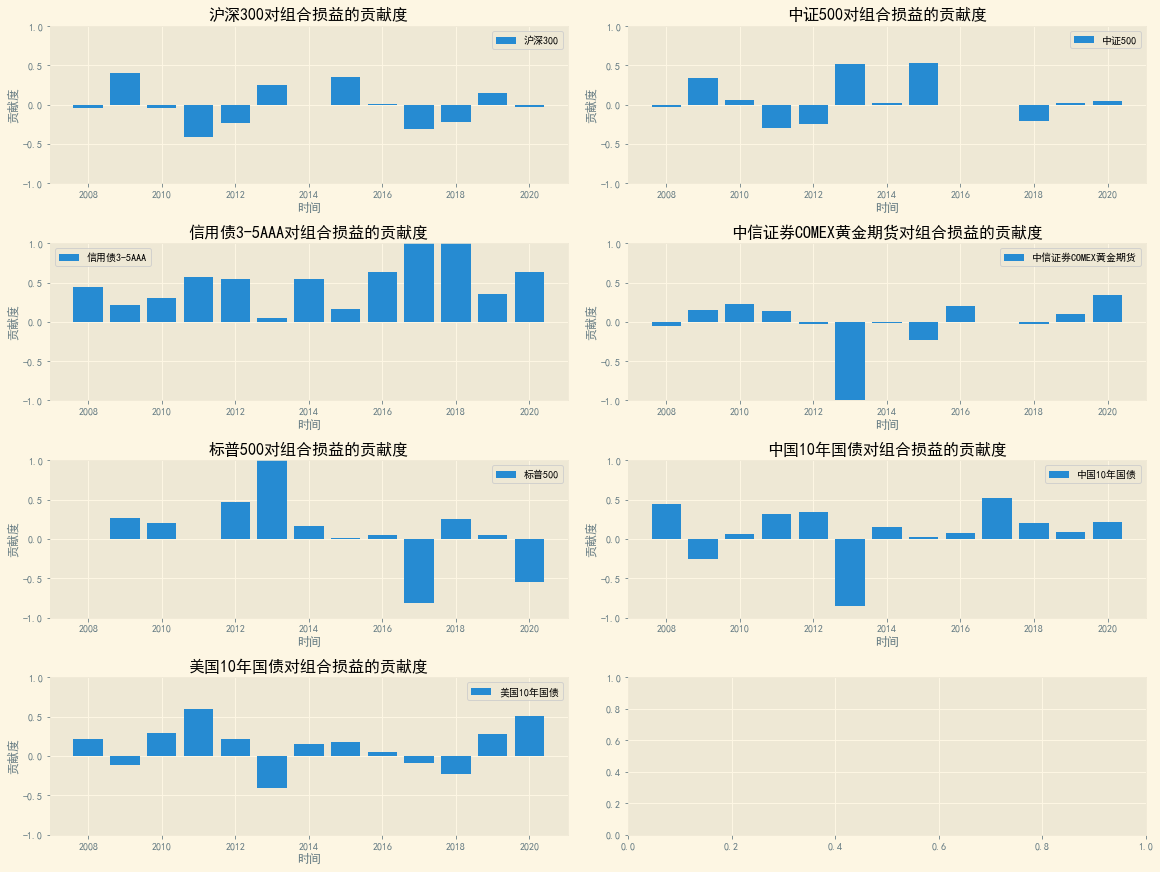

In [61]:
StatisticFunc.BarPlot(annualContrb_5, '横截面动量+时序动量+换手率+铜金D')

### 投资组合净值曲线

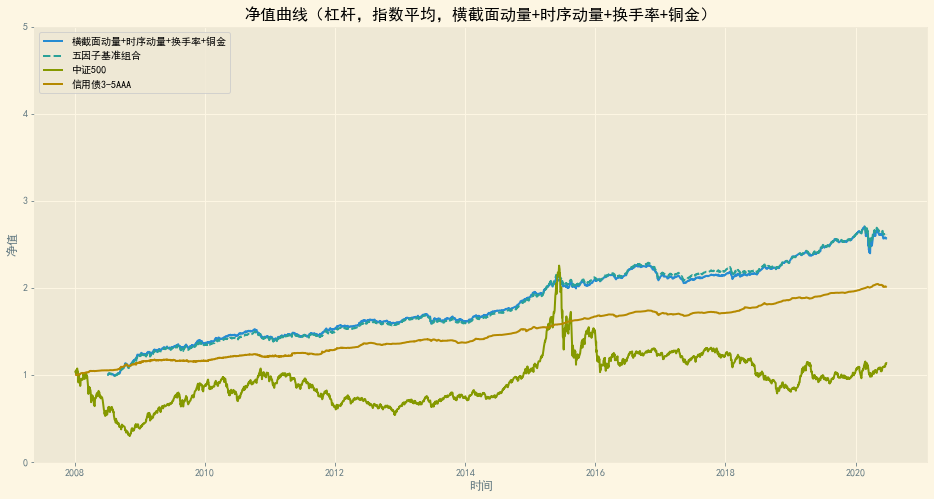

In [62]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')  
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金)D.png')

# 汇总比较

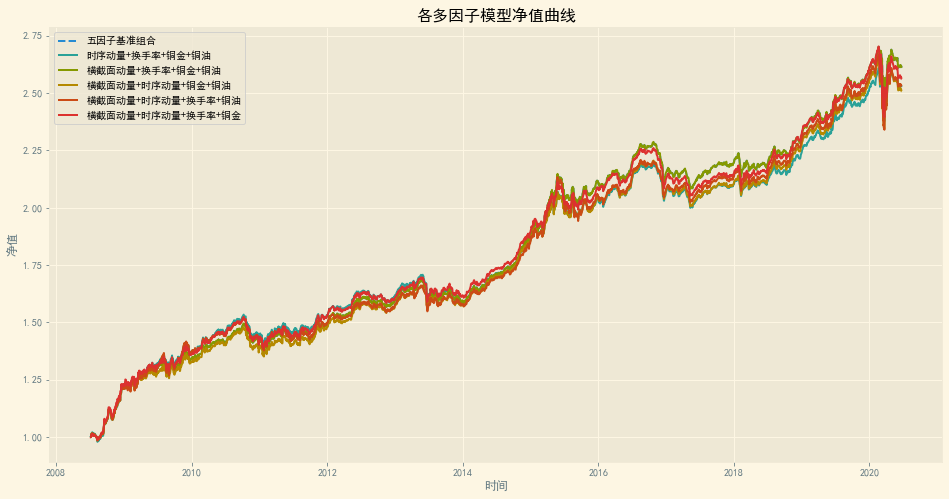

In [64]:
fig = plt.figure(figsize=(16, 8))



plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='时序动量+换手率+铜金+铜油')
plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量+换手率+铜金+铜油')
plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='横截面动量+时序动量+铜金+铜油')
plt.plot(tradeDF_5.index, tradeDF_4['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜油')
plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金')


plt.xlabel('时间')
plt.ylabel('净值')
plt.legend(loc='upper left')
plt.title('各多因子模型净值曲线')
plt.savefig('各多因子模型净值曲线D.png')